In [16]:
import pandas as pd
from sklearn import preprocessing

from gnnad.graphanomaly import GNNAD
from gnnad.plot import plot_test_anomalies, plot_predictions, plot_sensor_error_scores

def normalise(X, scaler_fn):
    scaler = scaler_fn.fit(X)
    return pd.DataFrame(scaler.transform(X), index=X.index, columns = X.columns)

In [17]:
# read in training data
X_train = pd.read_csv('./examples/herbert_train.csv', index_col=0)
X_train.index = pd.to_datetime(X_train.index)

# read in test data
X_tmp = pd.read_csv('./examples/herbert_test.csv', index_col=0)
X_tmp.index = pd.to_datetime(X_tmp.index)
X_test = X_tmp.iloc[:,:8]
y_test = X_tmp.iloc[:,8:].apply(any, axis=1)

# normalise
X_test = normalise(X_test, preprocessing.StandardScaler())
X_train = normalise(X_train, preprocessing.StandardScaler())

# create ANOOMS dict for plotting
ANOMS = {'type1': {}}
X_test_anoms = X_tmp.iloc[:,8:]

for i in range(len(X_test_anoms.columns)):
    anom_col_name = X_test_anoms.columns[i]
    sensor_col_name = X_test.columns[i]
    anom_idxs = X_test_anoms[anom_col_name][X_test_anoms[anom_col_name]].index

    if len(anom_idxs) > 0:
        ANOMS['type1'][sensor_col_name] = anom_idxs

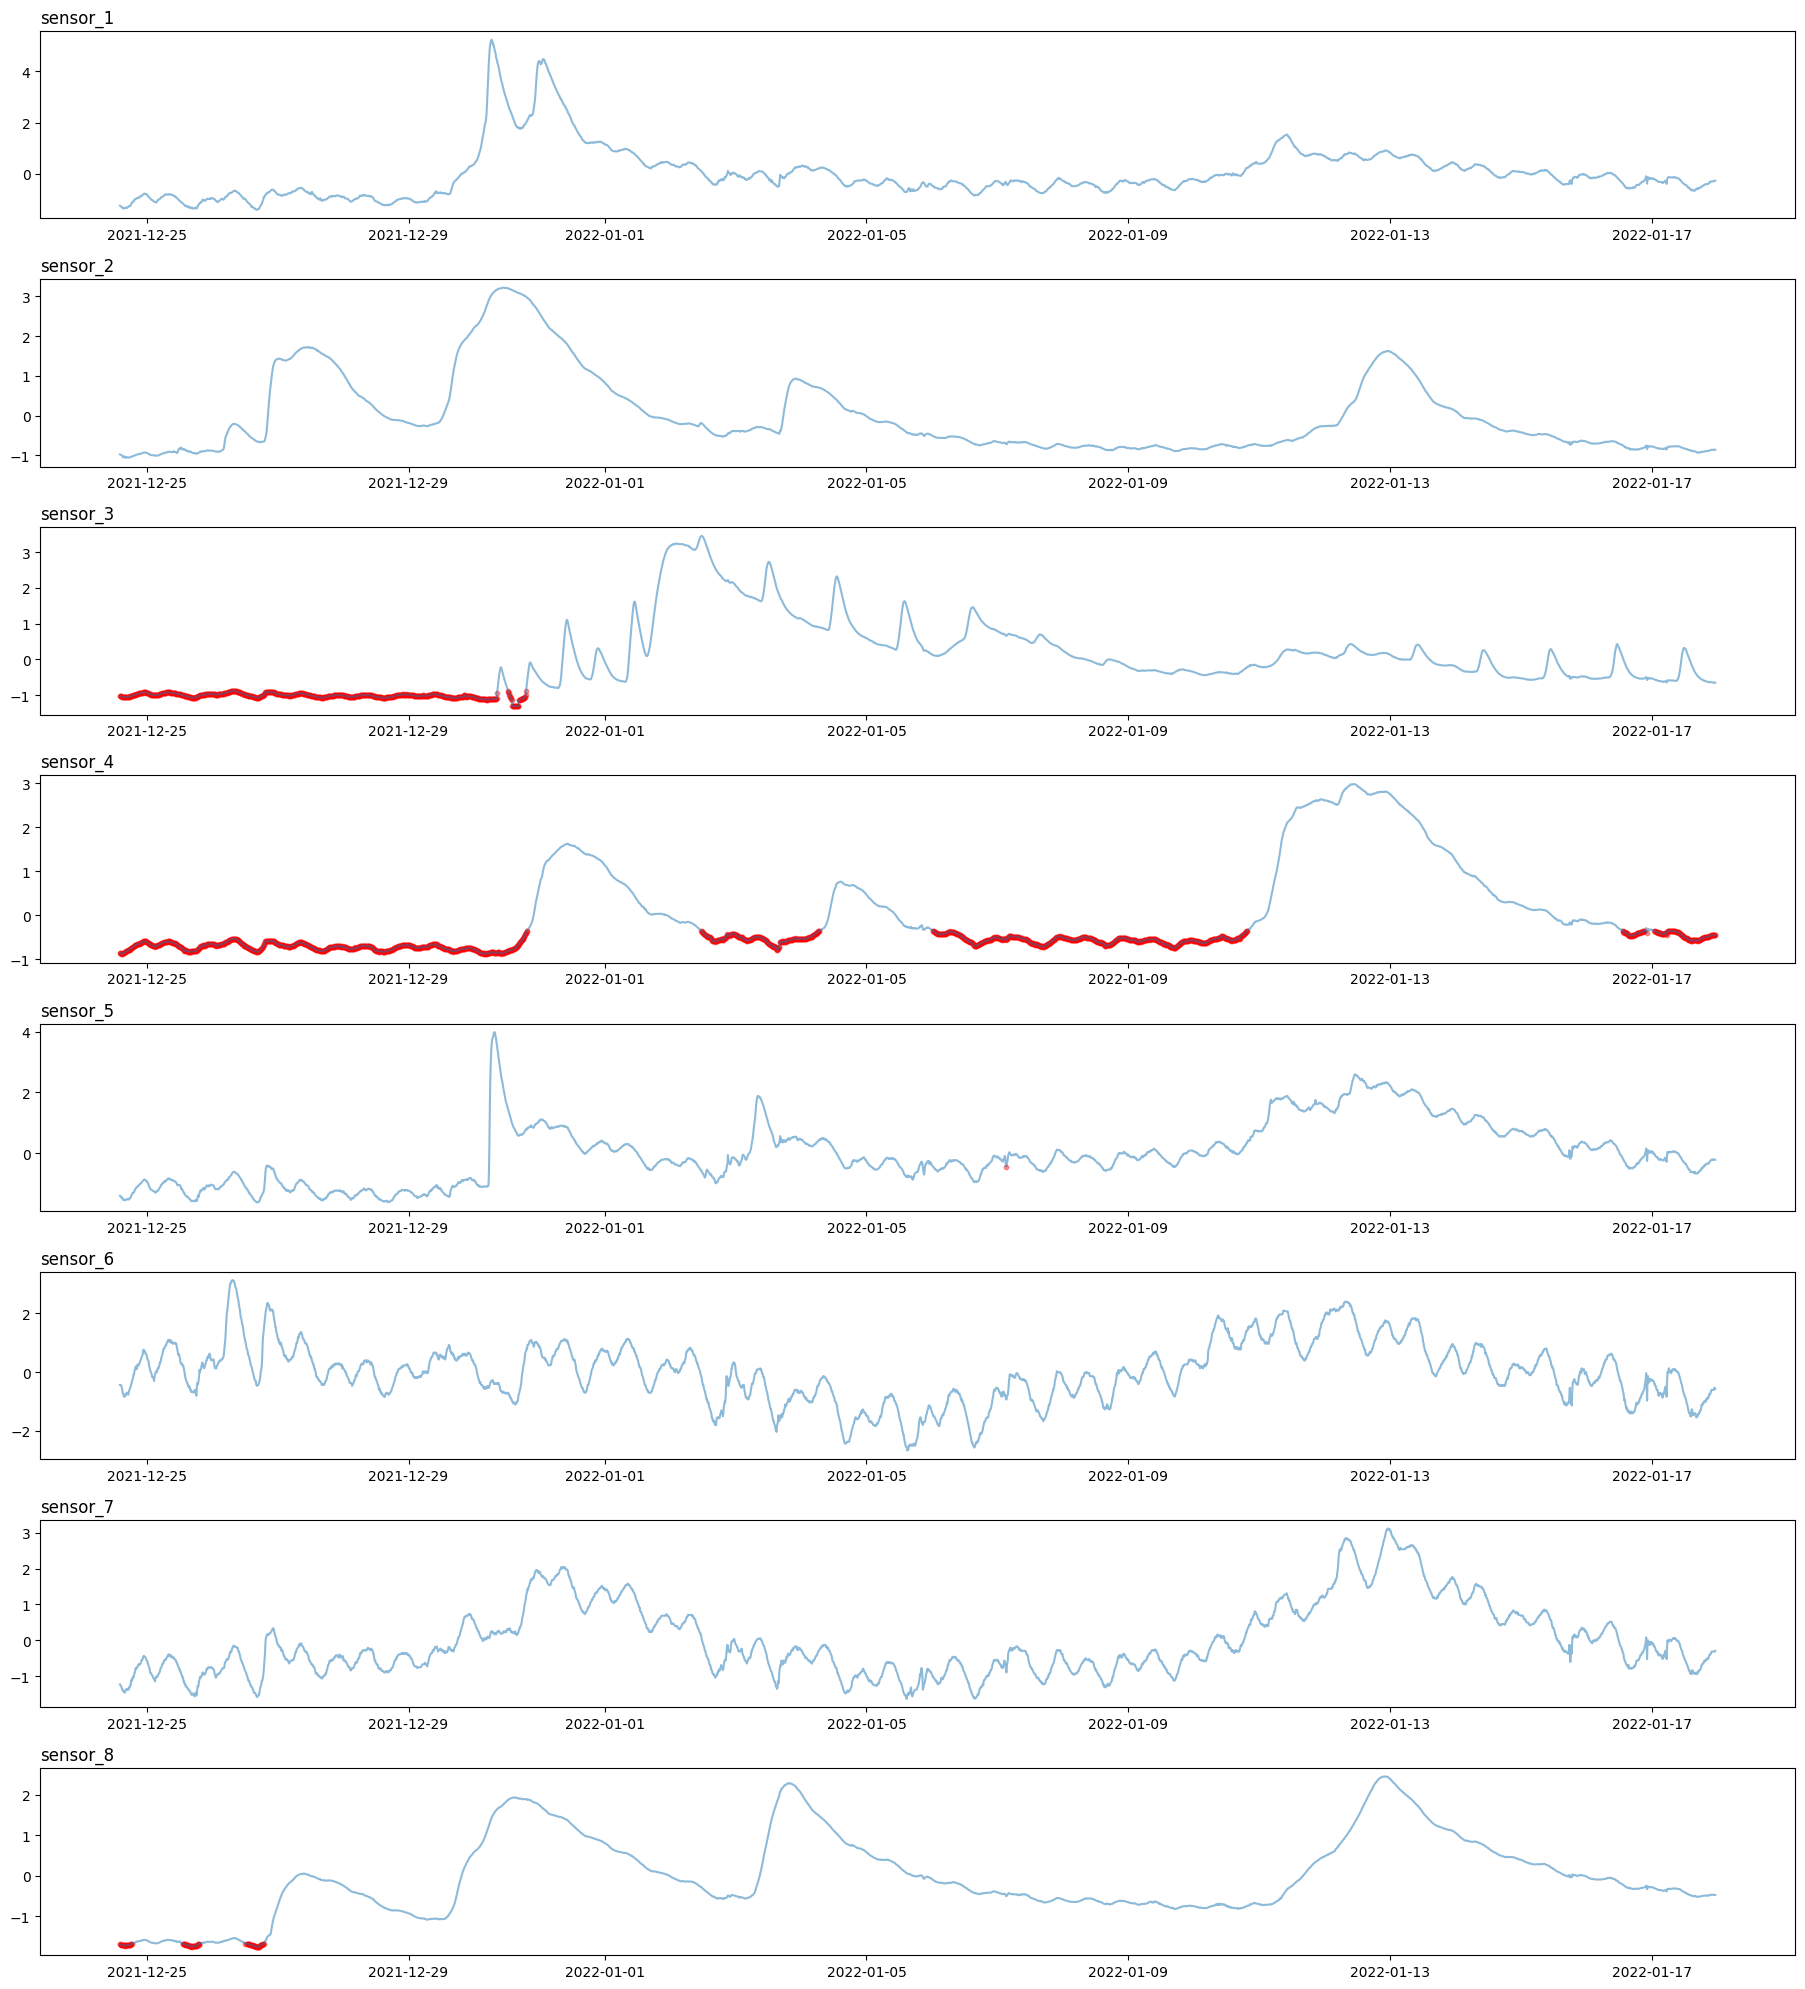

In [18]:
# plot input data
plot_test_anomalies(X_test, ANOMS)

In [19]:
print('train size:', X_train.shape)
print('test size:', X_test.shape)

train size: (12745, 8)
test size: (3499, 8)


In [20]:
print('sliding window count:', 12545 / 5 + 1)

sliding window count: 2510.0


In [21]:
# run model

"""
Default Hyperparameters of GNNAD

batch: int = 128,
epoch: int = 100,
slide_win: int = 15,
embed_dim: int = 64,
slide_stride: int = 5,
random_seed: int = 0,
out_layer_num: int = 1,
out_layer_inter_dim: int = 256,
decay: float = 0,
validate_ratio: float = 0.1,
topk: int = 20,
device: str = "cpu",
save_model_name: str = "",
early_stop_win: int = 15,
lr: float = 0.001,
shuffle_train: bool = True,
threshold_type: str = None,
suppress_print: bool = False,
smoothen_error: bool = True,
use_deterministic: bool = False
"""

model = GNNAD(threshold_type="max_validation", topk=6, slide_win=200, epoch = 2)
fitted_model = model.fit(X_train, X_test, y_test)


a
Gated Edge Index: tensor([[0, 5, 2, 1, 3, 6, 1, 6, 4, 2, 3, 7, 2, 7, 4, 3, 5, 1, 3, 4, 2, 7, 1, 6,
         4, 7, 3, 1, 2, 6, 5, 7, 0, 6, 2, 1, 6, 1, 5, 7, 4, 2, 7, 4, 5, 2, 3, 6],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
         4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7]])
Gated Edge Index: tensor([[0, 5, 2, 1, 3, 6, 1, 6, 4, 2, 3, 7, 2, 7, 4, 3, 5, 1, 3, 4, 2, 7, 1, 6,
         4, 7, 3, 1, 2, 6, 5, 7, 0, 6, 2, 1, 6, 1, 5, 7, 4, 2, 7, 4, 5, 2, 3, 6],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
         4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7]])
Gated Edge Index: tensor([[0, 5, 2, 1, 3, 6, 1, 6, 4, 2, 3, 7, 2, 7, 4, 3, 5, 1, 3, 4, 2, 7, 1, 6,
         4, 7, 3, 1, 2, 6, 5, 7, 0, 6, 2, 1, 6, 1, 5, 7, 4, 2, 7, 4, 5, 2, 3, 6],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
         4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6

In [22]:
# model summary
fitted_model.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                   [-1, 64]             512
         Embedding-2                   [-1, 64]             512
            Linear-3                   [-1, 64]          12,800
    SumAggregation-4                [-1, 1, 64]               0
        GraphLayer-5                   [-1, 64]              64
       BatchNorm1d-6                   [-1, 64]             128
              ReLU-7                   [-1, 64]               0
          GNNLayer-8                   [-1, 64]               0
         Embedding-9                   [-1, 64]             512
      BatchNorm1d-10                [-1, 64, 8]             128
          Dropout-11                [-1, 8, 64]               0
           Linear-12                 [-1, 8, 1]              65
         OutLayer-13                 [-1, 8, 1]               0
Total params: 14,721
Trainable params: 

In [21]:
# GDN+, sensor thresholds
preds = fitted_model.sensor_threshold_preds(tau = 99)
fitted_model.print_eval_metrics(preds)


recall: 9.5
precision: 61.4
accuracy: 46.4
specificity: 92.5
f1: 16.5


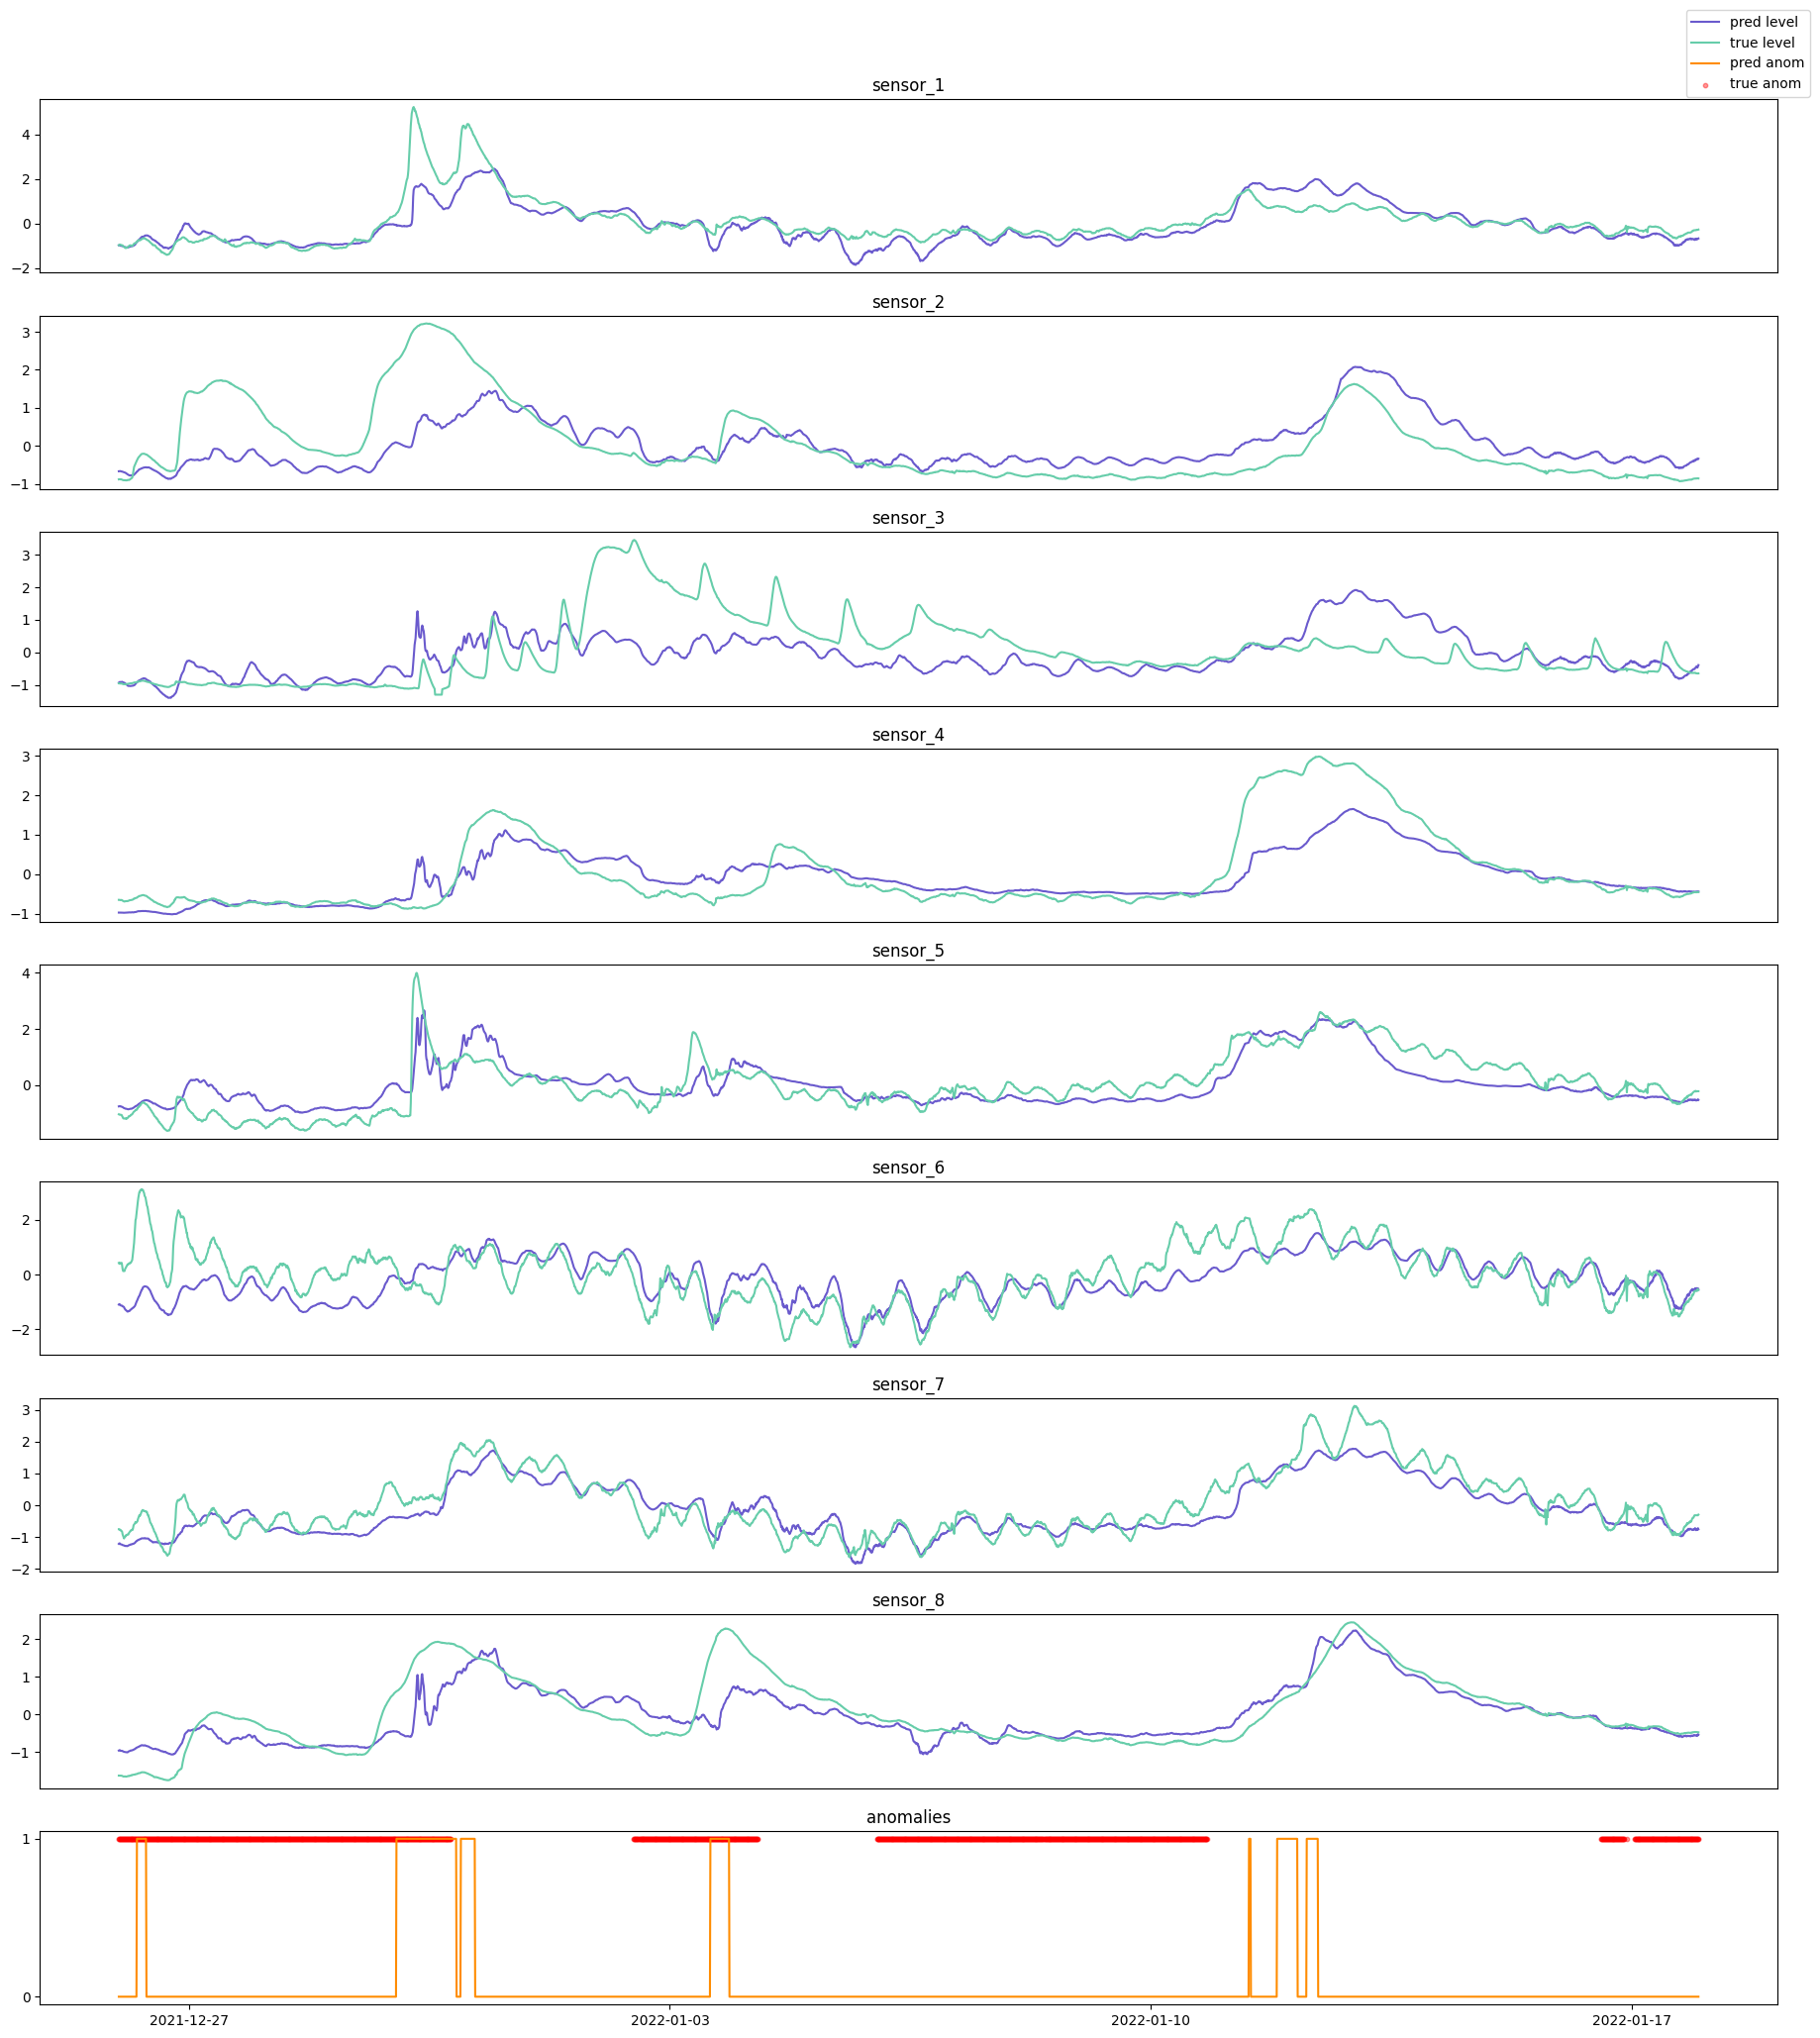

In [22]:
# plot predictions
plot_predictions(fitted_model, X_test, ANOMS, preds = preds, figsize=(20, 20))


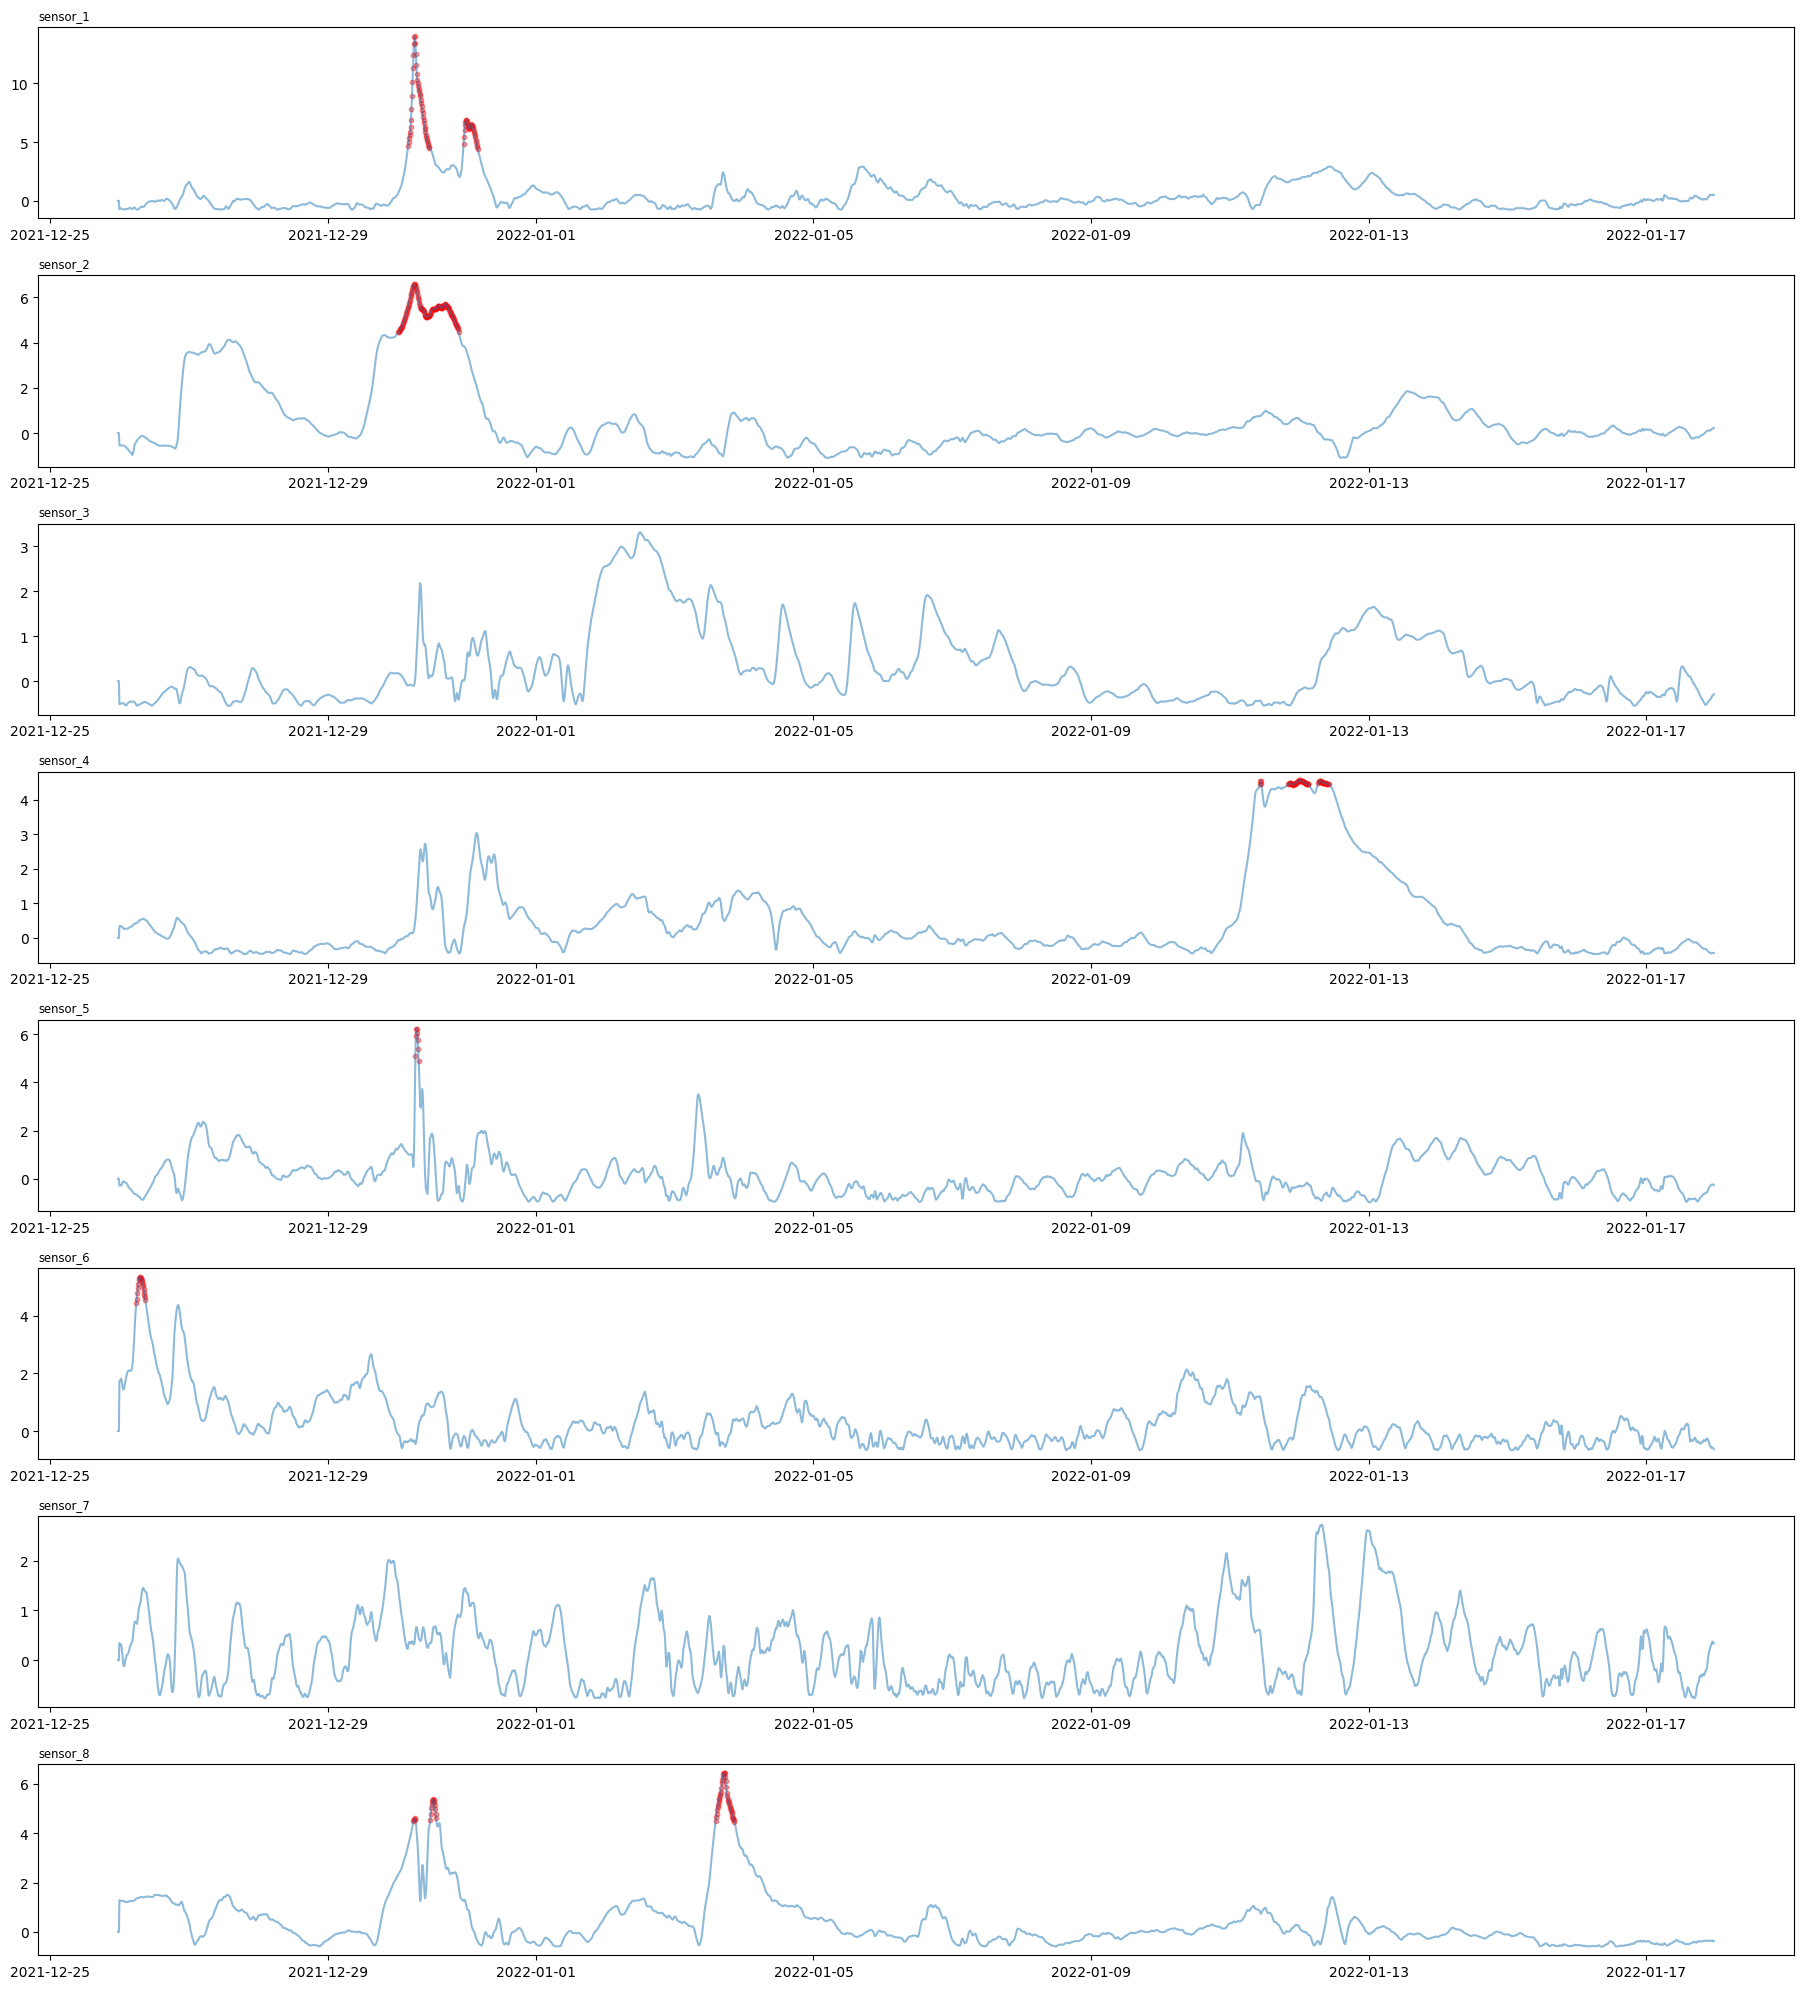

In [23]:
plot_sensor_error_scores(fitted_model, X_test)